# Normal distribution
* [1D](#1D)
* [2D no spatial covariance](#2D-no-spatial-covariance)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la

## Model

In [2]:
def curve(x):
    return (x/10)**3 - 6*(x/10)**2 + 4*x/10 + 30

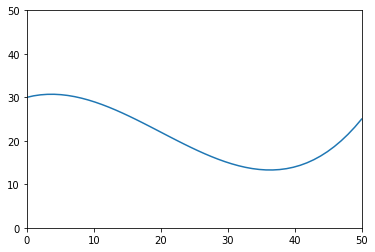

In [3]:
x = np.linspace(0, 50)
y = curve(x)

plt.figure()
plt.plot(x, y)
plt.xlim(0,50)
plt.ylim(0,50)
plt.show()

## Probability density function
\begin{align}
    {\displaystyle f(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}}
\end{align}

In [4]:
def normal(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( - 0.5 * ( (x - mu)/sigma )**2 )

### 1D

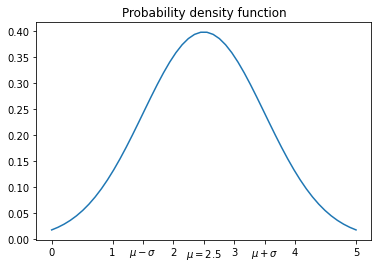

In [5]:
x = np.linspace(0,5)
y = normal(x, 2.5, 1.)

plt.figure()
plt.title('Probability density function')
plt.plot(x, y)
plt.xticks([0, 1, 2.5-1., 2.0, 2.5, 3, 2.5+1, 4, 5], [0, 1, '$\\mu-\\sigma$', 2, '$\\mu=2.5$', 3, '$\\mu+\\sigma$', 4, 5])
plt.show()

### 2D no spatial covariance

In [6]:
def generate_normal(i, j):
    v = curve(i)
    
    mu = np.ones_like(i, dtype=np.float64)
    type1 = v >= j
    mu[ type1 ] = 15.
    
    type2 = v < j
    mu[ type2 ] = 7.
    
    variance = np.zeros_like(i, dtype=np.float64)
    variance = np.abs(v - j)
    variance /= np.max(variance)
    variance = 1 - variance
    
    return mu, variance

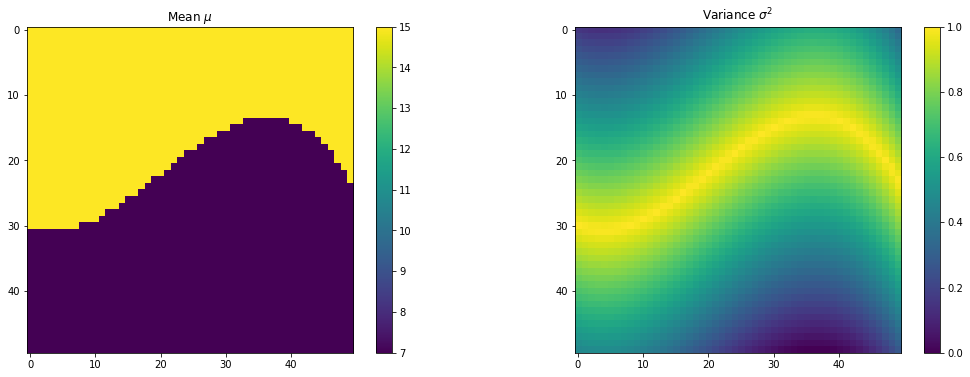

In [7]:
x = np.arange(50)
y = np.arange(50)
xx, yy = np.meshgrid(x, y)

mean, variance = generate_normal(xx, yy)

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Mean $\mu$')
plt.imshow(mean)
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Variance $\sigma^2$')
plt.imshow(variance)
plt.colorbar()
plt.show()

#### Realization

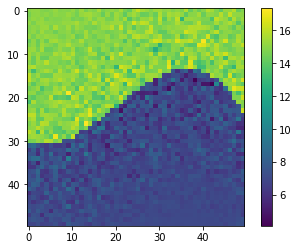

In [8]:
sample = np.random.normal(mean, variance)

plt.figure()
plt.imshow(sample)
plt.colorbar()
plt.show()